# Use AutoAI and Lale to predict credit risk with `ibm-watson-machine-learning`

This notebook contains the steps and code to demonstrate support of AutoAI experiments in Watson Machine Learning service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines, refining pipelines, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.7.


## Learning goals

The learning goals of this notebook are:

-  Work with Watson Machine Learning experiments to train AutoAI models.
-  Compare trained models quality and select the best one for further refinement.
-  Refine the best model and test new variations.
-  Online deployment and score the trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Optimizer definition](#definition)
3.	[Experiment Run](#run)
4.	[Pipelines comparison and testing](#comparison)
5.	[Historical runs](#runs)
6.	[Pipeline refinement and testing](#refinery)
7.	[Deploy and Score](#scoring)
8.  [Clean up](#cleanup)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `password`.

In [1]:
username = 'PASTE YOUR USERNAME HERE'
password = 'PASTE YOUR PASSWORD HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
wml_credentials = {
    "username": username,
    "password": password,
    "url": url,
    "instance_id": 'openshift',
    "version": '3.5'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install -U ibm-watson-machine-learning | tail -n 1

In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [5]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [7]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## 2. Optimizer definition

### Training data connection

Define connection information to training data CSV file. This example uses the German Credit Risk dataset. 

The dataset can be downloaded from [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/data/credit_risk/german_credit_data_biased_training.csv).

In [8]:
filename = 'credit_risk_training.csv'

In [ ]:
!wget https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd3.5/data/credit_risk/german_credit_data_biased_training.csv \
    -O credit_risk_training.csv

In [9]:
asset_details = client.data_assets.create('german_credit_data_biased_training', filename)
asset_details

Creating data asset...
SUCCESS


{'metadata': {'space_id': '9700fa57-fc2e-4eff-b22f-7eecec0b2858',
  'guid': 'c6f8fd7a-c98d-43bf-a514-c591039c6263',
  'href': '/v2/assets/c6f8fd7a-c98d-43bf-a514-c591039c6263?space_id=9700fa57-fc2e-4eff-b22f-7eecec0b2858',
  'asset_type': 'data_asset',
  'created_at': '2020-10-22T12:40:09Z',
  'last_updated_at': '2020-10-22T12:40:09Z'},
 'entity': {'data_asset': {'mime_type': 'text/csv'}}}

In [10]:
from ibm_watson_machine_learning.helpers import DataConnection, AssetLocation


credit_risk_conn = DataConnection(
    location=AssetLocation(asset_id=client.data_assets.get_id(asset_details)))

training_data_reference=[credit_risk_conn]

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [11]:
from ibm_watson_machine_learning.experiment import AutoAI

experiment = AutoAI(wml_credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction - AutoAI',
    desc='Sample notebook',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
)

Configuration parameters can be retrieved via `get_params()`.

In [12]:
pipeline_optimizer.get_params()

{'name': 'Credit Risk Prediction - AutoAI',
 'desc': 'Sample notebook',
 'prediction_type': 'binary',
 'prediction_column': 'Risk',
 'scoring': 'roc_auc',
 'test_size': 0.1,
 'max_num_daub_ensembles': 1,
 't_shirt_size': 'm',
 'train_sample_rows_test_size': None,
 'daub_include_only_estimators': ['ExtraTreesClassifierEstimator',
  'GradientBoostingClassifierEstimator',
  'LGBMClassifierEstimator',
  'LogisticRegressionEstimator',
  'RandomForestClassifierEstimator',
  'XGBClassifierEstimator',
  'DecisionTreeClassifierEstimator'],
 'cognito_transform_names': None,
 'data_join_graph': False,
 'csv_separator': ',',
 'excel_sheet': 0,
 'encoding': 'utf-8',
 'positive_label': None,
 'run_id': None}

<a id="run"></a>
## 3. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [13]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job 609876a4-6d1b-4249-b0ec-bc793bf3ce06 completed: 100%|█| 200/200 [16:09<00:00,  4.85s/it


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [14]:
pipeline_optimizer.get_run_status()

'completed'

<a id="comparison"></a>
## 4. Pipelines comparison and testing

You can list trained pipelines and evaluation metrics information in
the form of a Pandas DataFrame by calling the `summary()` method. You can
use the DataFrame to compare all discovered pipelines and select the one
you like for further testing.

In [15]:
summary = pipeline_optimizer.summary()
summary

,Number of enhancements,Estimator,training_roc_auc_(optimized),holdout_precision,training_average_precision,holdout_average_precision,training_neg_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,holdout_neg_log_loss,training_accuracy,holdout_roc_auc,training_balanced_accuracy,training_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_4,3,XGBClassifierEstimator,0.853924,0.709877,0.787632,0.762729,-0.433111,0.688623,0.684669,0.802,0.773741,0.660013,0.699088,-0.436499,0.784444,0.859614,0.753430,0.671769
Pipeline_3,2,XGBClassifierEstimator,0.852990,0.693750,0.784678,0.765166,-0.435542,0.664671,0.687841,0.790,0.758762,0.651364,0.678899,-0.437189,0.784222,0.858697,0.751107,0.668659
Pipeline_2,1,XGBClassifierEstimator,0.852343,0.702532,0.786014,0.765052,-0.435526,0.664671,0.689205,0.794,0.761765,0.654025,0.683077,-0.434657,0.785556,0.858661,0.752772,0.670906
Pipeline_1,0,XGBClassifierEstimator,0.849883,0.692810,0.782921,0.760481,-0.437680,0.634731,0.692303,0.784,0.746795,0.638057,0.662500,-0.438008,0.783778,0.854903,0.747457,0.663639


You can visualize the scoring metric calculated on a holdout data set.

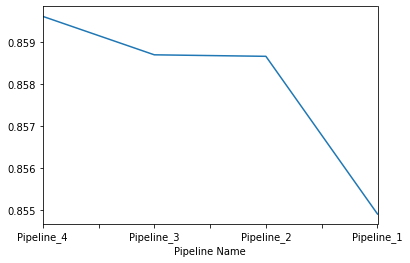

In [16]:
%matplotlib inline

summary.holdout_roc_auc.plot();

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [17]:
best_pipeline = pipeline_optimizer.get_pipeline()

Check confusion matrix for selected pipeline.

In [18]:
pipeline_optimizer.get_pipeline_details()['confusion_matrix']

,fn,fp,tn,tp
true_class,,,,
No Risk,47,52,115,286
Risk,52,47,286,115


Check features importance for selected pipeline.

In [19]:
pipeline_optimizer.get_pipeline_details()['features_importance']

,features_importance
NewFeature_0_product(LoanDuration__Age),1.00
NewFeature_2_max(LoanDuration__product(LoanDuration__Age)),0.77
NewFeature_6_max(product(LoanDuration__LoanAmount)__product(LoanAmount__Age)),0.64
OthersOnLoan,0.63
CurrentResidenceDuration,0.62
ExistingCreditsCount,0.46
Telephone,0.43
OwnsProperty,0.40
NewFeature_4_max(Age__product(LoanDuration__Age)),0.37
EmploymentDuration,0.29


### Convert the pipeline model to a Python script and download it

In [20]:
from ibm_watson_machine_learning.helpers import pipeline_to_script
pipeline_to_script(best_pipeline)

### Visualize pipeline

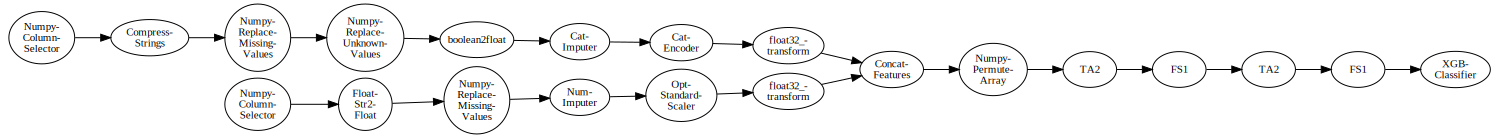

In [21]:
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.

### Pipeline source code

In [ ]:
best_pipeline.pretty_print(ipython_display=True)

In the pretty-printed code, `>>` is the pipe combinator (dataflow
edge) and `&` is the and combinator (combining multiple subpipelines).
They correspond to the `make_pipeline` and `make_union` functions from
scikit-learn, respectively. If you prefer the functions, you can
instead pretty-print your pipeline with
`best_pipeline.pretty_print(ipython_display=True, combinators=False)`.

### Reading training data

In [23]:
train_df = pipeline_optimizer.get_data_connections()[0].read()

train_X = train_df.drop(['Risk'], axis=1).values
train_y = train_df.Risk.values

### Test pipeline model locally

In [24]:
predicted_y = best_pipeline.predict(train_X)
predicted_y[:5]

array(['No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk'], dtype=object)

<a id="runs"></a>
## 5. Historical runs

In this section you learn to work with historical AutoPipelines fit jobs (runs).

To list historical runs use method `list()`. You can filter runs by providing experiment name.

In [25]:
experiment.runs(filter='Credit Risk Prediction - AutoAI').list()

,timestamp,run_id,state,auto_pipeline_optimizer name
0,2020-10-22T12:56:44.838Z,609876a4-6d1b-4249-b0ec-bc793bf3ce06,completed,Credit Risk Prediction - AutoAI
1,2020-10-22T12:03:34.417Z,9a914340-33a6-432f-830e-9afd2ee6d2dc,completed,Credit Risk Prediction - AutoAI


To work with historical pipelines found during a particular optimizer
run, you need to first provide the `run_id` to select the fitted
optimizer.

**ACTION:** assign selected run_id to the `run_id` variable.

In [26]:
run_id = 'PASTE YOUR RUN ID HERE'

### Get executed optimizer's configuration parameters

In [29]:
experiment.runs(filter='Credit Risk Prediction - AutoAI').get_params(run_id=run_id)

{'name': 'Credit Risk Prediction - AutoAI',
 'desc': 'Sample notebook',
 'prediction_type': 'binary',
 'prediction_column': 'Risk',
 'scoring': 'roc_auc',
 'test_size': 0.1,
 'max_num_daub_ensembles': 1.0,
 't_shirt_size': 'c076e82c-b2a7-4d20-9c0f-1f0c2fdf5a24',
 'daub_include_only_estimators': ['ExtraTreesClassifierEstimator',
  'GradientBoostingClassifierEstimator',
  'LGBMClassifierEstimator',
  'LogisticRegressionEstimator',
  'RandomForestClassifierEstimator',
  'XGBClassifierEstimator',
  'DecisionTreeClassifierEstimator'],
 'cognito_transform_names': None,
 'train_sample_rows_test_size': None,
 'csv_separator': ',',
 'excel_sheet': 0,
 'encoding': 'utf-8'}


### Get historical optimizer instance and training details

In [30]:
historical_opt = experiment.runs.get_optimizer(run_id)

In [31]:
run_details = historical_opt.get_run_details()

### List trained pipelines for selected optimizer

In [32]:
historical_opt.summary()

,Number of enhancements,Estimator,training_roc_auc_(optimized),holdout_precision,training_average_precision,holdout_average_precision,training_neg_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,holdout_neg_log_loss,training_accuracy,holdout_roc_auc,training_balanced_accuracy,training_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_4,3,XGBClassifierEstimator,0.853924,0.709877,0.787632,0.762729,-0.433111,0.688623,0.684669,0.802,0.773741,0.660013,0.699088,-0.436499,0.784444,0.859614,0.753430,0.671769
Pipeline_3,2,XGBClassifierEstimator,0.852990,0.693750,0.784678,0.765166,-0.435542,0.664671,0.687841,0.790,0.758762,0.651364,0.678899,-0.437189,0.784222,0.858697,0.751107,0.668659
Pipeline_2,1,XGBClassifierEstimator,0.852343,0.702532,0.786014,0.765052,-0.435526,0.664671,0.689205,0.794,0.761765,0.654025,0.683077,-0.434657,0.785556,0.858661,0.752772,0.670906
Pipeline_1,0,XGBClassifierEstimator,0.849883,0.692810,0.782921,0.760481,-0.437680,0.634731,0.692303,0.784,0.746795,0.638057,0.662500,-0.438008,0.783778,0.854903,0.747457,0.663639


### Get selected pipeline and test locally

In [33]:
hist_pipeline = historical_opt.get_pipeline(pipeline_name='Pipeline_3')

In [34]:
predicted_y = hist_pipeline.predict(train_X)
predicted_y[:5]

array(['No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk'], dtype=object)

---

<a id="refinery"></a>
## 6. Pipeline refinement with [Lale](https://github.com/IBM/lale) and testing

In this section you learn how to refine and retrain the best
pipeline returned by AutoAI. There are many ways to refine a pipeline.
For illustration, simply replace the final estimator in the
pipeline by an interpretable model. The call to
`wrap_imported_operators()` augments scikit-learn operators with
schemas for hyperparameter tuning.

In [35]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import Hyperopt
from lale import wrap_imported_operators

wrap_imported_operators()

### Pipeline decomposition and new definition

Start by removing the last step of the pipeline, i.e., the final estimator.

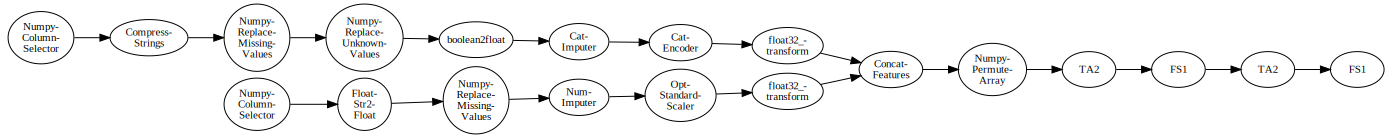

In [36]:
prefix = hist_pipeline.remove_last().freeze_trainable()
prefix.visualize()

Next, add a new final step, which consists of a choice of three
estimators. In this code, `|` is the or combinator (algorithmic
choice). It defines a search space for another optimizer run.

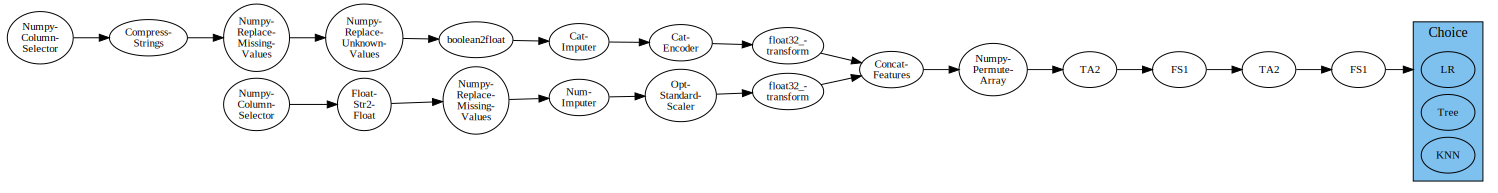

In [37]:
new_pipeline = prefix >> (LR | Tree | KNN)
new_pipeline.visualize()

### New optimizer `Hyperopt` configuration and training

To automatically select the algorithm and tune its hyperparameters, we
create an instance of the `Hyperopt` optimizer and `fit` it to the
data.

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.15, random_state=33)

In [39]:
hyperopt = Hyperopt(estimator=new_pipeline, cv=3, max_evals=20, scoring='roc_auc')
hyperopt_pipelines = hyperopt.fit(X_train, y_train)

100%|██████████| 20/20 [03:01<00:00,  9.08s/trial, best loss: -0.7983051783779822]


In [40]:
pipeline_model = hyperopt_pipelines.get_pipeline()

### Pipeline model tests and visualization

In [41]:
from sklearn.metrics import roc_auc_score

predicted_y = pipeline_model.predict(X_test)
score = roc_auc_score(predicted_y=='Risk', y_test=='Risk')
print(f'roc_auc_score {score:.1%}')

roc_auc_score 72.6%


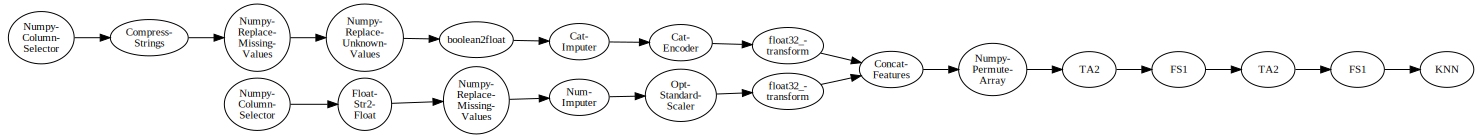

In [42]:
pipeline_model.visualize()

<a id="scoring"></a>
## 7. Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice and batch using WML instance.

### Webservice deployment creation

In [43]:
from ibm_watson_machine_learning.deployment import WebService

service = WebService(wml_credentials, source_space_id=space_id)

service.create(
    experiment_run_id=run_id,
    model=pipeline_model, 
    deployment_name="Credit Risk Deployment AutoAI")

Preparing an AutoAI Deployment...
Depreciation Warning: Passing an object will no longer be supported. Please specify the AutoAI model name to deploy.
Published model uid: 316f1872-f0e2-43ee-a6c1-7ea9bce2aa36
Deploying model 316f1872-f0e2-43ee-a6c1-7ea9bce2aa36 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '316f1872-f0e2-43ee-a6c1-7ea9bce2aa36' started

#######################################################################################


initializing..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ff048d8e-d217-4c42-98e4-9a0d7f5d1eee'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [44]:
print(service)

name: Credit Risk Deployment AutoAI, id: ff048d8e-d217-4c42-98e4-9a0d7f5d1eee, scoring_url: https://obmoct19-cpd-obmoct19.apps.ocp45wmlupgrade.cp.fyre.ibm.com/ml/v4/deployments/ff048d8e-d217-4c42-98e4-9a0d7f5d1eee/predictions, asset_id: 316f1872-f0e2-43ee-a6c1-7ea9bce2aa36


To show all available information about the deployment use the `.get_params()` method:

In [45]:
service.get_params()

{'entity': {'asset': {'id': '316f1872-f0e2-43ee-a6c1-7ea9bce2aa36'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'c076e82c-b2a7-4d20-9c0f-1f0c2fdf5a24',
   'name': 'M',
   'num_nodes': 1},
  'hybrid_pipeline_hardware_specs': [{'hardware_spec': {'name': 'S',
     'num_nodes': 1},
    'node_runtime_id': 'auto_ai.kb'}],
  'name': 'Credit Risk Deployment AutoAI',
  'online': {},
  'space_id': '9700fa57-fc2e-4eff-b22f-7eecec0b2858',
  'status': {'online_url': {'url': 'https://obmoct19-cpd-obmoct19.apps.ocp45wmlupgrade.cp.fyre.ibm.com/ml/v4/deployments/ff048d8e-d217-4c42-98e4-9a0d7f5d1eee/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2020-10-22T13:02:13.130Z',
  'id': 'ff048d8e-d217-4c42-98e4-9a0d7f5d1eee',
  'modified_at': '2020-10-22T13:02:13.130Z',
  'name': 'Credit Risk Deployment AutoAI',
  'owner': '1000330999',
  'space_id': '9700fa57-fc2e-4eff-b22f-7eecec0b2858'}}

### Scoring of webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [46]:
predictions = service.score(payload=train_df.drop(['Risk'], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.7674418604651163, 0.23255813953488372]],
    ['No Risk', [0.9186046511627907, 0.08139534883720931]],
    ['No Risk', [0.9418604651162791, 0.05813953488372093]],
    ['No Risk', [0.6744186046511628, 0.32558139534883723]],
    ['Risk', [0.22093023255813954, 0.7790697674418605]],
    ['Risk', [0.13953488372093023, 0.8604651162790697]],
    ['No Risk', [0.7906976744186046, 0.20930232558139536]],
    ['No Risk', [0.7093023255813954, 0.29069767441860467]],
    ['No Risk', [0.813953488372093, 0.18604651162790697]],
    ['Risk', [0.3023255813953488, 0.6976744186046512]]]}]}

If you want to work with the web service in an external Python application you can retrieve the service object by:
 - Initialize the service by `service = WebService(wml_credentials)`
 - Get deployment_id by `service.list()` method
 - Get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

### Deleting deployment
You can delete the existing deployment by calling the `service.delete()` command.
To list the existing web services you can use `service.list()`.

### Batch deployment creation

A batch deployment processes input data from a inline data and return predictions in scoring details or processes from data asset and writes the output to a file.

In [47]:
batch_payload_df = train_df.drop(['Risk'], axis=1)[:5]
batch_payload_df

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,CurrentResidenceDuration,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,3,savings_insurance,32,none,own,1,skilled,1,none,yes
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,2,savings_insurance,37,stores,own,2,skilled,1,none,yes
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,3,real_estate,28,none,own,2,skilled,1,yes,no
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,2,savings_insurance,32,none,own,1,skilled,1,none,yes
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,3,unknown,57,none,own,2,skilled,1,none,yes


Create batch deployment for `Pipeline_2` created in AutoAI experiment with the `run_id`.

In [48]:
from ibm_watson_machine_learning.deployment import Batch

service_batch = Batch(wml_credentials,source_space_id=space_id)
service_batch.create(
            experiment_run_id=run_id,
            model="Pipeline_2",
            deployment_name="Credit Risk Batch Deployment AutoAI")

Preparing an AutoAI Deployment...
Published model uid: 8e630be3-ee55-42a7-8552-03f10ee49009
Deploying model 8e630be3-ee55-42a7-8552-03f10ee49009 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '8e630be3-ee55-42a7-8552-03f10ee49009' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e031e9b8-798e-48f9-b966-d20f8aa06f3f'
------------------------------------------------------------------------------------------------




### Score batch deployment with inline payload as pandas DataFrame.

In [49]:
scoring_params = service_batch.run_job(
            payload=batch_payload_df,
            background_mode=False)



##########################################################################

Synchronous scoring for id: 'acb788e1-acb1-45d1-ab7d-4244148d984a' started

##########################################################################


queued..
running
completed
Scoring job  'acb788e1-acb1-45d1-ab7d-4244148d984a' finished successfully.


In [50]:
scoring_params['entity']['scoring'].get('predictions')

[{'fields': ['prediction', 'probability'],
  'values': [['No Risk', [0.804153323173523, 0.19584669172763824]],
   ['No Risk', [0.8490337133407593, 0.15096625685691833]],
   ['No Risk', [0.8802725076675415, 0.11972751468420029]],
   ['No Risk', [0.7487887144088745, 0.2512113153934479]],
   ['Risk', [0.1557828187942505, 0.8442171812057495]]]}]

### Score batch deployment with payload as data asset.

Save pandas DataFrame with batch payload to file and crate new data asset with the file.

In [51]:
from ibm_watson_machine_learning.helpers.connections import AssetLocation, DeploymentOutputAssetLocation


batch_payload_filename = "credit_risk_batch_payload.csv"
batch_payload_df.to_csv(batch_payload_filename, index=False)

asset_details = client.data_assets.create(
            name=batch_payload_filename,
            file_path=batch_payload_filename)
asset_id = client.data_assets.get_id(asset_details)

payload_reference = DataConnection(location=AssetLocation(asset_id=asset_id))
results_reference = DataConnection(
            location=DeploymentOutputAssetLocation(name="batch_output_credit_risk.csv"))

Creating data asset...
SUCCESS


Run scoring job for batch deployment.

In [52]:
scoring_params = service_batch.run_job(
            payload=[payload_reference],
            output_data_reference=results_reference,
            background_mode=False)



##########################################################################

Synchronous scoring for id: '89853318-a95c-4d3e-baf6-131ee66d3d57' started

##########################################################################


queued.........
running.
completed
Scoring job  '89853318-a95c-4d3e-baf6-131ee66d3d57' finished successfully.


### Deleting deployment
You can delete the existing deployment by calling the `service_batch.delete()` command.
To list the existing: 
- batch services you can use `service_batch.list()`, 
- scoring jobs you can use `service_batch.list_jobs()`.

<a id="cleanup"></a>
## 8. Clean up 

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 9. Summary and next steps

 You successfully completed this notebook!.
 
 You learned how to use `ibm-watson-machine-learning` to run AutoAI experiments. 
 
 Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

**Amadeusz Masny**, Python Software Developer in Watson Machine Learning at IBM

**Kiran Kate**, Senior Software Engineer at IBM Research AI

**Martin Hirzel**, Research Staff Member and Manager at IBM Research AI

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.